In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
# from ipyleaflet import Map, basemaps, basemap_to_tiles, 
import folium
from geopy import distance
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook, tqdm_pandas,trange
from tqdm.auto import tqdm
# import psycopg2

In [3]:
# Text imports

import Levenshtein
from fuzzywuzzy import fuzz
# import nltk
# from nltk.tokenize import word_tokenize
import re
import gensim

from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

# 0. Read data

Сохранил в пикл для удобства в ноутбуке `explore.ipynb`

In [4]:
df_pairs = pd.read_pickle('../data/df_pairs.pkl')
df_offers = pd.read_pickle('../data/df_offers.pkl')
df_geo = pd.read_pickle('../data/df_geo.pkl')
df_building = pd.read_pickle('../data/df_building.pkl')
df_bargainterms = pd.read_pickle('../data/df_bargainterms.pkl')

# 1. Geo

### preproc

In [5]:
df_geo['userInput'] = df_geo['userInput'].str.replace('Россия, ', '')
df_geo['userInput'] = df_geo['userInput'].str.strip()

### feats

In [6]:
# расстояние левенштейна между адресами
geo_addr_lev1 = [
    Levenshtein.distance(a,b) for a,b in zip(
        df_geo.loc[df_pairs['offer_id1']]['userInput'],
        df_geo.loc[df_pairs['offer_id2']]['userInput']
    )
]


# расстояние левенштейна чуть по-другому
geo_addr_lev2 = [
    Levenshtein.distance(''.join(a), ''.join(b))  for a,b in zip(
        df_geo.loc[df_pairs['offer_id1']]['address'].apply(lambda addr: [x['name'] for x in addr]),
        df_geo.loc[df_pairs['offer_id2']]['address'].apply(lambda addr: [x['name'] for x in addr])
    )
]

# то же самое с fuzzywuzzy
geo_addr_fw = [
    fuzz.ratio(a,b)/100 for a,b in zip(
        df_geo.loc[df_pairs['offer_id1']]['userInput'],
        df_geo.loc[df_pairs['offer_id2']]['userInput']
    )
]

In [7]:
# расстояние между гео-координатами

geo_distances = [
    distance.geodesic(a,b).km for a,b in zip(
        df_geo.loc[df_pairs['offer_id1']][['lat', 'lon']].values,
        df_geo.loc[df_pairs['offer_id2']][['lat', 'lon']].values
    )
]

In [8]:
# еще одна метрика близости в адресе

geo_addr_percent_intersect = [
    len(np.intersect1d(a, b)) / max(len(a), len(b)) for a,b in zip(
        df_geo.loc[df_pairs['offer_id1']]['address'].apply(lambda addr: [x['name'] for x in addr]),
        df_geo.loc[df_pairs['offer_id2']]['address'].apply(lambda addr: [x['name'] for x in addr])
    )
]

In [9]:
# собираем в одно

df_feats_geo_all = pd.DataFrame(
    np.array([geo_addr_lev1, geo_addr_lev2, geo_addr_percent_intersect, geo_addr_fw, geo_distances]).T,
    columns=["geo_addr_lev1", "geo_addr_lev2", "geo_addr_percent_intersect", "geo_addr_fw", "geo_distances"]
)

# 2. Text

### preproc

In [10]:
import spacy
nlp = spacy.load('../spacy-ru/ru2/', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

cleaning = lambda doc: [token.lemma_ for token in doc if not token.is_stop]

In [11]:
brief_cleaning = [re.sub("[^A-Za-zА-Яа-я']+", ' ', str(row)).lower() for row in df_offers['description']]
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
# txt = [cleaning(doc) for doc in docs]

In [12]:
stop_words = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь","будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная","важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг","ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне","вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать","восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми","всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз","говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно","даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый","двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел","делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго","должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое","другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать","же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем","здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно","иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как","какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая","которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли","лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее","меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная","многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может","может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над","надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша","наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного","нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой","никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну","нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды","однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно","остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать","плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить","помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом","потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь","пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше","ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим","самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего","своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас","семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько","слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем","спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть","считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя","твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того","тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут","ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть","хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый","четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать","шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту","я","являюсь"]

In [13]:
df_offers['txt_processed'] = [' '.join(token) for token in txt]

#### неудавшаяся попытка сделать поиск по латинским символам в описании

### w2v  features

строим док2век на собственном обученном w2v

In [14]:
w2vmodel_my = gensim.models.KeyedVectors.load_word2vec_format('../models/wv300cian.model')

In [15]:

from scipy.spatial.distance import cosine

def sent2vec(s, w2vmodel):
    
    featureVec = np.zeros((300,), dtype="float32")
    nwords = 0
                               
    for w in s.split(' '):                                   
        try:                                       
            nwords = nwords + 1                                       
            featureVec = np.add(featureVec, w2vmodel[w])
        except:                                       
            continue                               
        # averaging                               
        if nwords > 0:                                   
            featureVec = np.divide(featureVec, nwords)
    return featureVec

def get_w2v_vectors(list_text1, list_text2, w2vmodel): 
    '''
    Computing the word2vec vector representation of list of sentences
    @param list_text1 : first list of sentences
    @param list_text2 : second list of sentences 
    '''
    print("Computing first vectors…")
    text1_vectors = np.zeros((len(list_text1), 300))
    for i, q in tqdm(enumerate(list_text1)):
        text1_vectors[i, :] = sent2vec(q, w2vmodel)
    text2_vectors = np.zeros((len(list_text2), 300))
    for i, q in tqdm(enumerate(list_text2)):
        text2_vectors[i, :] = sent2vec(q, w2vmodel)
    return text1_vectors, text2_vectors

def cosine_similarity_my(list_vec1, list_vec2):
    '''
    Computing the cosine similarity between two vector representation
    @param  list_text1  :   first list of sentences
    @param  list_text2  :   second list of sentences 
    '''
    cosine_dist = [cosine(x, y) for (x, y) in zip(np.nan_to_num(list_vec1), np.nan_to_num(list_vec2))]
    cosine_sim = [(1 - dist) for dist in cosine_dist]
    return cosine_sim

In [16]:
vectors = get_w2v_vectors(
    df_offers.loc[df_pairs['offer_id1']]['txt_processed'].values,
    df_offers.loc[df_pairs['offer_id2']]['txt_processed'].values,
    w2vmodel_my
)

Computing first vectors…


In [17]:
txt_similarity_feature = cosine_similarity_my(*vectors)

### text stats

Здесь простые количественные признаки, часть в итоге выборшено

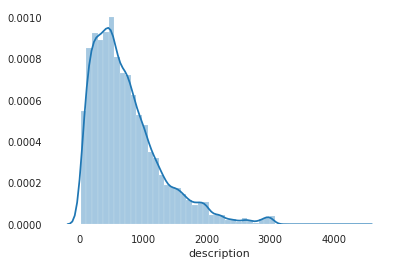

In [18]:
sns.distplot(df_offers.description.str.len())

In [19]:
df_offers['eng_percentage_letters'] = \
df_offers['description'].apply(
    lambda x: 
    np.mean([1 if l in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ' else 0 for l in x]))

df_offers['dots_count'] = \
df_offers['description'].apply(
    lambda x: 
    np.sum([1 if l in '.,\\/#!$%^&*;:{}=-_`~()' else 0 for l in x]))

In [20]:
text_len = [
    min(a,b)/max(a,b) for a,b in zip(
        df_offers.loc[df_pairs['offer_id1']]['description'].str.len().values,
        df_offers.loc[df_pairs['offer_id2']]['description'].str.len().values
    )
]

eng_perc = [
    1 if max(a,b)==0 else min(a,b)/max(a,b) for a,b in zip(
        df_offers.loc[df_pairs['offer_id1']]['eng_percentage_letters'].values,
        df_offers.loc[df_pairs['offer_id2']]['eng_percentage_letters'].values
    )
]
dots_perc = [
    1 if max(a,b)==0 else min(a,b)/max(a,b) for a,b in zip(
        df_offers.loc[df_pairs['offer_id1']]['dots_count'].values,
        df_offers.loc[df_pairs['offer_id2']]['dots_count'].values
    )
]

### tfidf

Тут были разные попытки векторайзеров, выиграл символьный с ngram 1-4

In [21]:
vectorizer24 = TfidfVectorizer("char", ngram_range=(1,4), sublinear_tf=True)
vectorizer24.fit(df_offers.txt_processed)

vec1 = vectorizer24.transform(df_offers.loc[df_pairs['offer_id1']]['txt_processed'])
vec2 = vectorizer24.transform(df_offers.loc[df_pairs['offer_id2']]['txt_processed'])

cosine_tfidf_ng = 1 - cosine_similarity(vec1,vec2).diagonal()

# cosine_tfidf_ng = []
# for i in tqdm_notebook(range(vec1.shape[0])):
#     cosine_tfidf_ng += [1 - cosine(vec1[i].todense(), vec2[i].todense())]

In [22]:
import pickle as pkl

In [46]:
with open('../models/vectorizer.model', 'wb') as f:
    pkl.dump(vectorizer24, f)

In [24]:
vectorizer_words = TfidfVectorizer(ngram_range=(1,4))
vectorizer_words.fit(df_offers.txt_processed)

vec1 = vectorizer_words.transform(df_offers.loc[df_pairs['offer_id1']]['txt_processed'])
vec2 = vectorizer_words.transform(df_offers.loc[df_pairs['offer_id2']]['txt_processed'])

In [25]:
cosine_tfidf_ng_words = 1 - cosine_similarity(vec1,vec2).diagonal()

In [26]:
# concat text
df_feats_text_all = pd.DataFrame(
    np.array([text_len, eng_perc, txt_similarity_feature, cosine_tfidf_ng]).T, 
    columns=["text_len", "eng_perc",'txt_similarity_feature',   "cosine_tfidf_ng"]
)


In [27]:
df_feats_text_all.iloc[0]

text_len                  0.459459
eng_perc                  0.621849
txt_similarity_feature    0.039052
cosine_tfidf_ng           0.889138
Name: 0, dtype: float64

# 3. Building

простые фичи по сравнению квартир

In [28]:
df_building.columns

Index(['buildYear', 'cargoLiftsCount', 'ceilingHeight', 'cranageTypes',
       'deadline', 'extinguishingSystemTypes', 'floorsCount',
       'hasGarbageChute', 'heatingType', 'infrastructure', 'liftTypes',
       'materialType', 'name', 'openingHours', 'parking',
       'passengerLiftsCount', 'series', 'totalArea'],
      dtype='object')

In [29]:
total_area_eq = [
    1 if abs(a-b)<=1 else 0 for a,b in zip(
        df_building.loc[df_pairs['offer_id1']]['totalArea'].fillna(0).values,
        df_building.loc[df_pairs['offer_id2']]['totalArea'].fillna(0).values
    )
]

In [30]:
rcnt_eq = [
    1 if a==b else 0 for a,b in zip(
        df_offers.loc[df_pairs['offer_id1']]['roomscount'].fillna(0).values,
        df_offers.loc[df_pairs['offer_id2']]['roomscount'].fillna(0).values
    )
]

In [31]:
# concat Building
df_feats_building_all = pd.DataFrame(
    np.array([total_area_eq, rcnt_eq]).T, 
    columns=["total_area_eq", "rcnt_eq"]
)

# 4. bargainterms

In [32]:
df_bargainterms.shape

(19266, 19)

In [33]:
deposit_rate = [
    1 if max(a,b)==0 else min(a,b)/max(a,b) for a,b in zip(
        df_bargainterms.loc[df_pairs['offer_id1']]['deposit'].fillna(0).values,
        df_bargainterms.loc[df_pairs['offer_id2']]['deposit'].fillna(0).values
    )
]

In [34]:
price_rate = [
    1 if max(a,b)==0 else min(a,b)/max(a,b) for a,b in zip(
        df_bargainterms.loc[df_pairs['offer_id1']]['price'].fillna(0).values,
        df_bargainterms.loc[df_pairs['offer_id2']]['price'].fillna(0).values
    )
]

In [35]:
df_feats_bargainterms_all = pd.DataFrame(
    np.array([deposit_rate, price_rate]).T, 
    columns=["deposit_rate", "price_rate"]
)

# CONCAT ALL

In [36]:
df_all = pd.concat([df_feats_geo_all, df_feats_text_all, df_feats_building_all, df_feats_bargainterms_all], axis=1)

In [37]:
df_all.columns

Index(['geo_addr_lev1', 'geo_addr_lev2', 'geo_addr_percent_intersect',
       'geo_addr_fw', 'geo_distances', 'text_len', 'eng_perc',
       'txt_similarity_feature', 'cosine_tfidf_ng', 'total_area_eq', 'rcnt_eq',
       'deposit_rate', 'price_rate'],
      dtype='object')

In [38]:
X = df_all[['geo_addr_lev1', 
            'geo_addr_lev2', 
            'geo_addr_percent_intersect',
            'geo_addr_fw',
            'geo_distances',
            'text_len',
            'eng_perc',
            'txt_similarity_feature', 
            #'txt_similarity_feature_external',
            'cosine_tfidf_ng',
#             'cosine_tfidf_ng_words',
#             'deposit_rate',
            'price_rate',
            'total_area_eq',
            'rcnt_eq'
           ]]#.fillna(0) # 
# X = df_all
y = np.array(df_pairs.resolution)

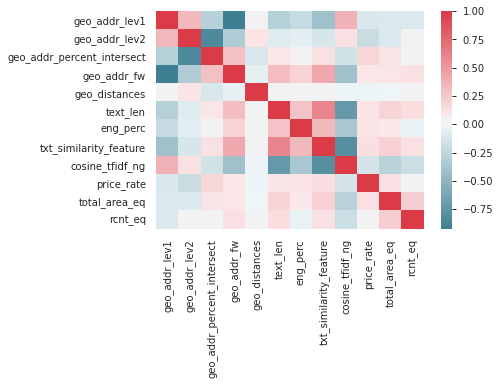

In [39]:
cor = X.corr()

# plot the heatmap
import seaborn as sns
sns.heatmap(cor, cmap = sns.diverging_palette(220, 10, as_cmap=True))

# Model 

In [40]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       610
           1       0.82      0.74      0.78      1390

    accuracy                           0.71      2000
   macro avg       0.67      0.69      0.68      2000
weighted avg       0.73      0.71      0.72      2000

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       623
           1       0.81      0.73      0.77      1377

    accuracy                           0.70      2000
   macro avg       0.66      0.68      0.66      2000
weighted avg       0.72      0.70      0.70      2000

              precision    recall  f1-score   support

           0       0.50      0.63      0.55       604
           1       0.82      0.72      0.77      1396

    accuracy                           0.69      2000
   macro avg       0.66      0.68      0.66      2000
weighted avg       0.72      0.69      0.70      2000

              preci

<Figure size 1296x936 with 0 Axes>

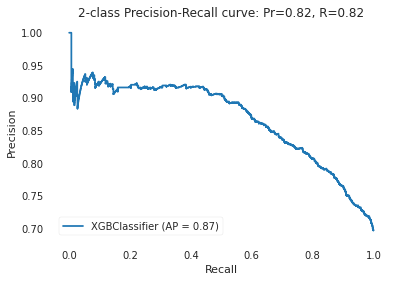

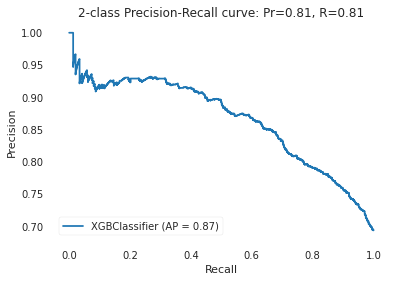

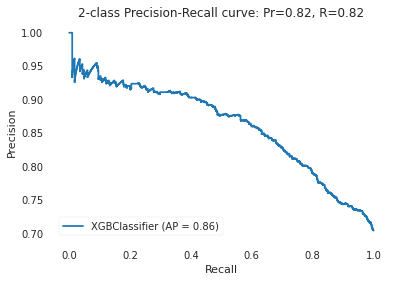

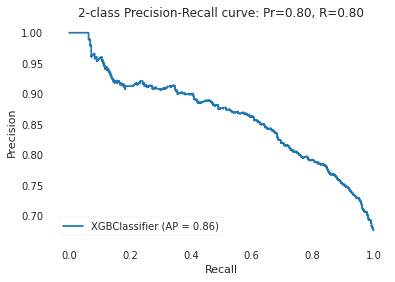

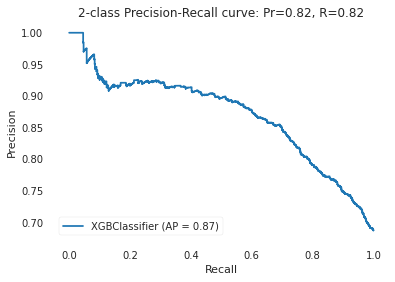

In [42]:

# CV model
model = xgb.XGBClassifier(
    colsample_bytree = 0.8,
    subsample = 0.8,
    objective='binary:logistic', 
    n_estimators=500, 
    max_depth=8,
    reg_alpha = 6
)

kfold = StratifiedKFold(n_splits=5, random_state=42)

prs = []
rcs = []

mean_recall = np.linspace(0, 1, 100)

plt.figure(figsize=(18 , 13))
kfold = KFold(n_splits=5, random_state=7)
i = 0
for train, test in kfold.split(X, y):
  
    model.fit(X.loc[train], y[train])
    probas = model.predict_proba(X.loc[test])
#     y_pred = model.predict(X.loc[test])
    y_pred = (probas[:,1]>0.65).astype(int)
    print(classification_report(y[test], y_pred))
    prs += [precision_score(y[test], y_pred)]
    rcs += [recall_score(y[test], y_pred)]
#     print(precision_recall_curve(y[test], probas[:,1]))
    disp = plot_precision_recall_curve(model, X.loc[test], y[test])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'Pr={0:0.2f}, R={0:0.2f}'.format(prs[i], rcs[i]))
    i += 1
    
print('mean precision: {0:0.2f}'.format(np.mean(prs)), 'mean recall: {0:0.2f}'.format(np.mean(rcs)))

### Результат

при пороге 0.65

* mean precision: 0.82
* mean recall: 0.75

In [43]:
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=6,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
model.save_model('../models/xgb.model')